In [2]:
# Soil Image Classification: Challenge 1
# https://www.kaggle.com/competitions/soil-classification

In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from PIL import UnidentifiedImageError, Image
from pathlib import Path


from collections import defaultdict

In [4]:
import seaborn as sns

In [5]:
# Step 3: Mount Google Drive or upload data via Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# ==== CONFIG ==== #



TRAIN_DIR = Path('/content/drive/MyDrive/soil-classification/soil_classification-2025/train/')
TEST_DIR = Path('/content/drive/MyDrive/soil-classification/soil_classification-2025/test/')

train_csv = '/content/drive/MyDrive/soil-classification/soil_classification-2025/train_labels.csv'
test_csv = '/content/drive/MyDrive/soil-classification/soil_classification-2025/test_ids.csv'


train_df = pd.read_csv(train_csv)

In [7]:
#List of files in TEST_DIR and to extarct Unique file extensions
test_files = os.listdir(TEST_DIR)

extensions = [os.path.splitext(f)[1].lower().replace(".", "") for f in test_files if os.path.isfile(os.path.join(TEST_DIR, f))]

# Count and display unique types
ext_counts = Counter(extensions)
print(" Unique image file types in test set:")
for ext, count in ext_counts.items():
    print(f" {ext}: {count} file(s)")


 Unique image file types in test set:
 jpg: 308 file(s)
 jpeg: 30 file(s)
 png: 1 file(s)
 gif: 1 file(s)
 webp: 1 file(s)


In [8]:
# List of files in TRAIN_DIR to extract Unique file extensions
train_files = os.listdir(TRAIN_DIR)

extensions = [os.path.splitext(f)[1].lower().replace(".", "") for f in train_files if os.path.isfile(os.path.join(TRAIN_DIR, f))]

# Count unique types
ext_counts = Counter(extensions)
print(" Unique image file types in training set:")
for ext, count in ext_counts.items():
    print(f"{ext}: {count} file(s)")


 Unique image file types in training set:
jpg: 1116 file(s)
jpeg: 92 file(s)
png: 6 file(s)
webp: 6 file(s)
gif: 2 file(s)


In [9]:
#Extratcing file name of special types (png, webp and gif for analysis)
import os

def list_specific_file_types(directory, extensions_to_find):
    files = os.listdir(directory)
    filtered_files = [f for f in files if os.path.isfile(os.path.join(directory, f))
                      and os.path.splitext(f)[1].lower().replace('.', '') in extensions_to_find]
    return filtered_files

target_extensions = {'png', 'webp', 'gif'}

train_specific_files = list_specific_file_types(TRAIN_DIR, target_extensions)
test_specific_files = list_specific_file_types(TEST_DIR, target_extensions)

# Display results
print(" Train images with png, webp, or gif extensions:")
for fname in train_specific_files:
    print("•", fname)

print("\n Test images with png, webp, or gif extensions:")
for fname in test_specific_files:
    print("•", fname)


 Train images with png, webp, or gif extensions:
• img_3050f4cb.png
• img_4bdf66f2.png
• img_622d25fd.webp
• img_60f71041.png
• img_850f28ec.webp
• img_831af63a.png
• img_923fc79a.gif
• img_9bf4b58d.webp
• img_a7aecb27.png
• img_b46efa76.png
• img_e2e8afd0.webp
• img_e15cf9ad.webp
• img_ed9ba5bd.gif
• img_2d5911bd.webp

 Test images with png, webp, or gif extensions:
• img_4f97095d.png
• img_91cbc6e5.gif
• img_f22972ea.webp


In [10]:
# 3. Image resolution stats
def get_image_dims(path_list):
    dims = []
    for file in path_list:
        try:
            with Image.open(file) as img:
                dims.append(img.size)
        except:
            continue
    return pd.DataFrame(dims, columns=["width", "height"])

train_files = list(TRAIN_DIR.glob("*"))
test_files = list(TEST_DIR.glob("*"))

train_dims_df = get_image_dims(train_files)
test_dims_df = get_image_dims(test_files)

# Outputs for visualization
(train_dims_df.describe(), test_dims_df.describe())


(             width       height
 count  1222.000000  1222.000000
 mean    628.774959   403.273322
 std     435.308120   260.160161
 min     100.000000    57.000000
 25%     266.000000   183.250000
 50%     453.500000   295.000000
 75%    1160.000000   522.000000
 max    2592.000000  1920.000000,
              width       height
 count   337.000000   337.000000
 mean    410.474777   298.522255
 std     376.490380   272.938627
 min     100.000000    57.000000
 25%     257.000000   183.000000
 50%     275.000000   192.000000
 75%     390.000000   280.000000
 max    2592.000000  1920.000000)

In [11]:
#Function to visulaize dataset (train/test)

def analyze_image_folder(folder_path, dataset_name="Dataset"):
    formats_count = defaultdict(int)
    dimensions = []
    file_sizes = []
    corrupt_files = []

    folder_path = Path(folder_path)

    # 🧪 Analyze each image
    for img_path in folder_path.iterdir():
        try:
            with Image.open(img_path) as img:
                formats_count[img.format.lower()] += 1
                dimensions.append(img.size)
                file_sizes.append(os.path.getsize(img_path))
        except UnidentifiedImageError:
            corrupt_files.append(img_path.name)

    # Skip analysis if no images were read
    if not dimensions:
        print(f"❌ No valid images found in {dataset_name}")
        return

    # 📈 Convert to arrays
    widths, heights = zip(*dimensions)
    aspect_ratios = np.array(widths) / np.array(heights)

    print(f"\n📂 {dataset_name} Analysis")
    print(f"⚠️ Corrupt/Unreadable Files: {len(corrupt_files)}")
    if corrupt_files:
        print("Corrupt file names:", corrupt_files)


    print(f"• Aspect Ratio: min={aspect_ratios.min():.2f}, max={aspect_ratios.max():.2f}")
    print(f"• File Size (KB): min={np.min(file_sizes)/1024:.1f}, max={np.max(file_sizes)/1024:.1f}, mean={np.mean(file_sizes)/1024:.1f}")

    return widths, heights, aspect_ratios, file_sizes



📂 Test Set Analysis
⚠️ Corrupt/Unreadable Files: 0
• Aspect Ratio: min=0.67, max=4.47
• File Size (KB): min=0.3, max=3124.9, mean=78.8


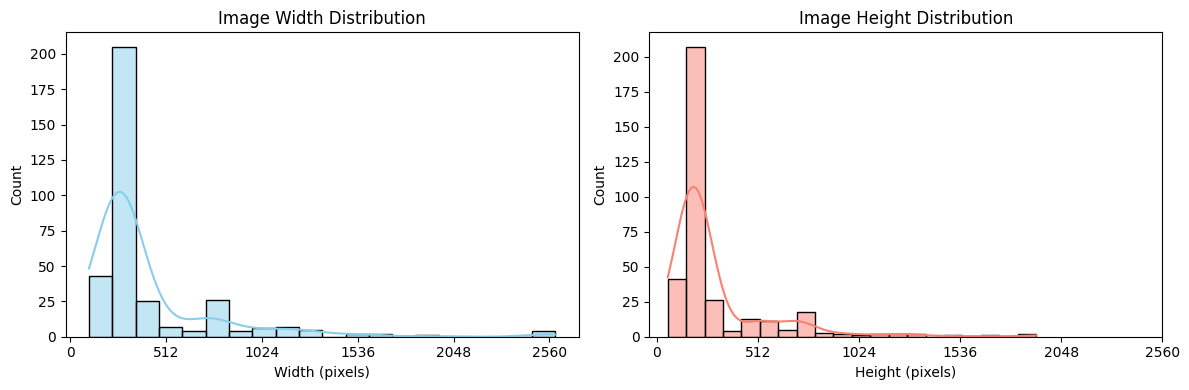

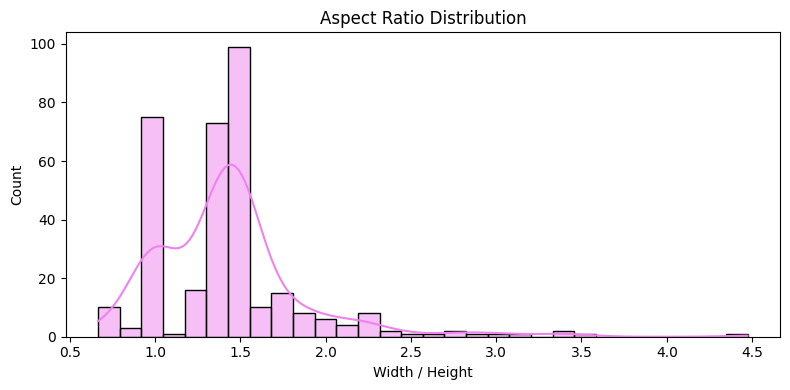

In [12]:
# TEST DATA Visualization + File size analysis

# Analyze Test Data
test_widths, test_heights, test_aspect_ratios, test_file_sizes = analyze_image_folder(TEST_DIR, dataset_name="Test Set")

# 📊 Plot: Width and Height Distribution (Side-by-side)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Width distribution
sns.histplot(test_widths, bins=20, ax=ax[0], kde=True, color="skyblue")
ax[0].set_title("Image Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_xticks([0, 512, 1024, 1536, 2048, 2560])

# Height distribution
sns.histplot(test_heights, bins=20, ax=ax[1], kde=True, color="salmon")
ax[1].set_title("Image Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 512, 1024, 1536, 2048, 2560])

plt.tight_layout()
plt.show()


# 📊 Plot: Aspect Ratio
plt.figure(figsize=(8, 4))
sns.histplot(test_aspect_ratios, bins=30, kde=True, color="violet")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()



📂 Train Set Analysis
⚠️ Corrupt/Unreadable Files: 0
• Aspect Ratio: min=0.52, max=4.47
• File Size (KB): min=0.3, max=3124.9, mean=100.4


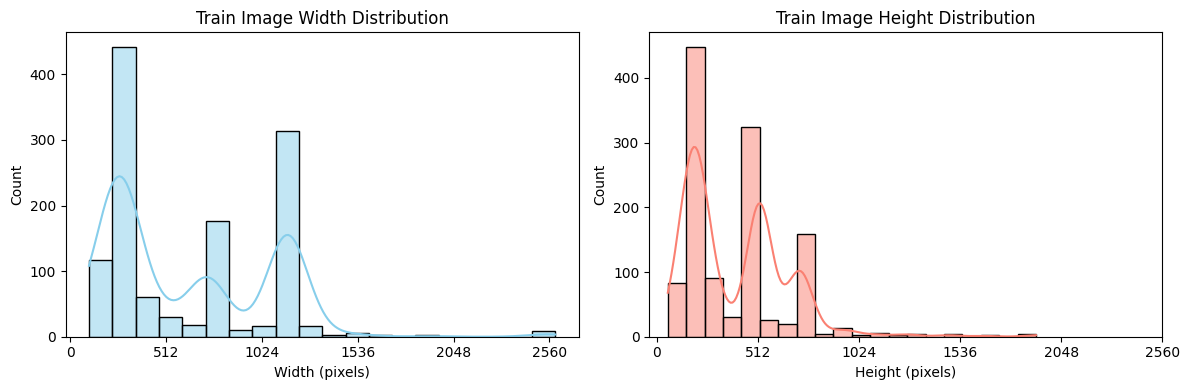

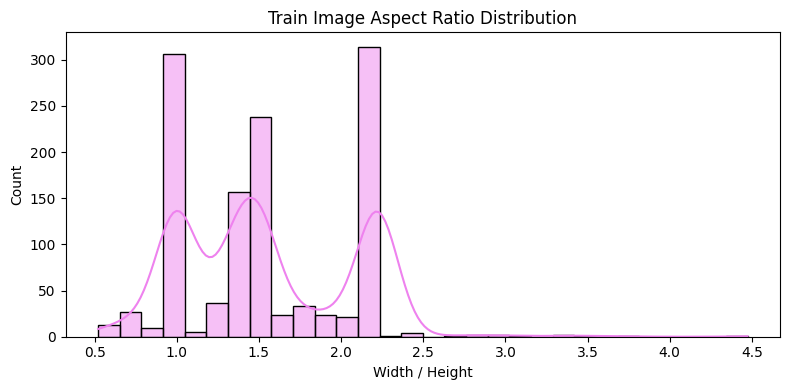

In [13]:
# Train DATA Visualization + File size analysis

# Analyze Train Data
train_widths, train_heights, train_aspect_ratios, train_file_sizes = analyze_image_folder(TRAIN_DIR, dataset_name="Train Set")

# 📊 Plot: Width and Height Distribution (Side-by-side)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Width distribution
sns.histplot(train_widths, bins=20, ax=ax[0], kde=True, color="skyblue")
ax[0].set_title("Train Image Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Count")
ax[0].set_xticks([0, 512, 1024, 1536, 2048, 2560])

# Height distribution
sns.histplot(train_heights, bins=20, ax=ax[1], kde=True, color="salmon")
ax[1].set_title("Train Image Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 512, 1024, 1536, 2048, 2560])

plt.tight_layout()
plt.show()


# 📊 Plot: Aspect Ratio
plt.figure(figsize=(8, 4))
sns.histplot(train_aspect_ratios, bins=30, kde=True, color="violet")
plt.title("Train Image Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.tight_layout()
plt.show()

In [14]:
#Main Model Computation

In [15]:
#Key values
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 8
LR = 1e-4

In [16]:
# ==== LOAD CSV ==== #
df = pd.read_csv(train_csv)
df['filename'] = df['image_id'].apply(lambda x: os.path.join(TRAIN_DIR, x))
label2idx = {label: i for i, label in enumerate(df['soil_type'].unique())}
idx2label = {i: label for label, i in label2idx.items()}
df['label_idx'] = df['soil_type'].map(label2idx)

In [17]:
# ==== WEIGHTED SAMPLER ==== #
class_counts = df['label_idx'].value_counts().to_dict()
weights = df['label_idx'].map(lambda x: 1.0 / class_counts[x])
sampler = WeightedRandomSampler(weights.values, len(weights))

# ==== DATASET CLASS ==== #
class SoilDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['filename']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = row.get('label_idx', -1)
        return image, label


In [18]:
# ==== TRANSFORMS ==== #
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ==== DATALOADERS ==== #
dataset = SoilDataset(df, transform=transform_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

# ==== MODEL ==== #
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label2idx))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [19]:

# ==== TRAINING ==== #

train_losses = []
train_accuracies = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")



100%|██████████| 39/39 [00:29<00:00,  1.32it/s]


Epoch 1/8 - Loss: 0.3595, Accuracy: 0.8846


100%|██████████| 39/39 [00:22<00:00,  1.75it/s]


Epoch 2/8 - Loss: 0.1145, Accuracy: 0.9689


100%|██████████| 39/39 [00:22<00:00,  1.73it/s]


Epoch 3/8 - Loss: 0.0816, Accuracy: 0.9787


100%|██████████| 39/39 [00:21<00:00,  1.79it/s]


Epoch 4/8 - Loss: 0.0775, Accuracy: 0.9804


100%|██████████| 39/39 [00:19<00:00,  1.97it/s]


Epoch 5/8 - Loss: 0.0465, Accuracy: 0.9885


100%|██████████| 39/39 [00:21<00:00,  1.84it/s]


Epoch 6/8 - Loss: 0.0324, Accuracy: 0.9894


100%|██████████| 39/39 [00:20<00:00,  1.93it/s]


Epoch 7/8 - Loss: 0.0266, Accuracy: 0.9918


100%|██████████| 39/39 [00:21<00:00,  1.81it/s]

Epoch 8/8 - Loss: 0.0440, Accuracy: 0.9861


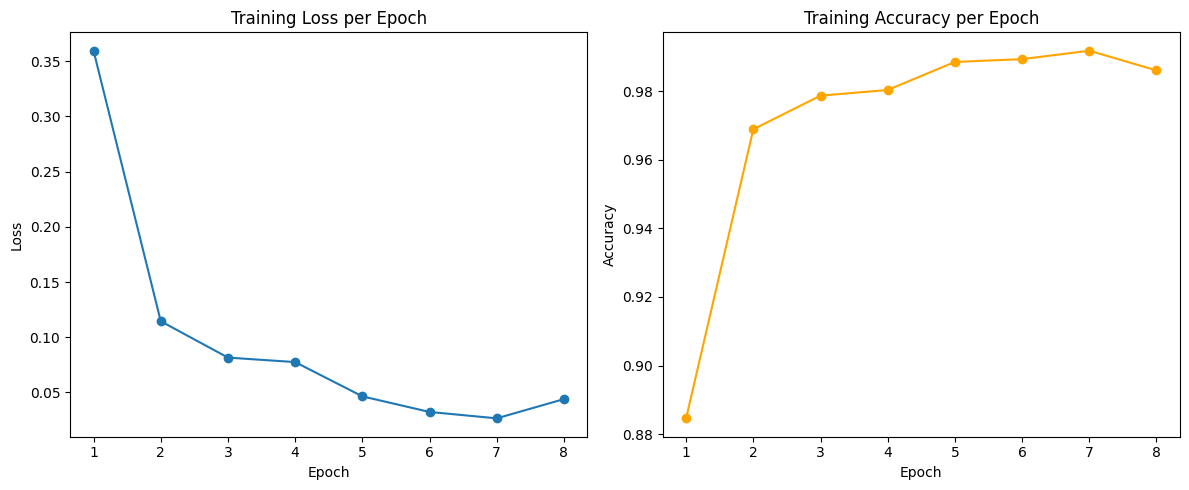

In [20]:
#new
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_accuracies, marker='o', color='orange')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [21]:
#new
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in DataLoader(dataset, batch_size=BATCH_SIZE):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [22]:
report = classification_report(all_labels, all_preds, target_names=[idx2label[i] for i in range(len(idx2label))], digits=4)
print("Classification Report:\n", report)

macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")


Classification Report:
                precision    recall  f1-score   support

Alluvial soil     1.0000    0.9981    0.9991       528
    Clay soil     1.0000    1.0000    1.0000       199
     Red soil     1.0000    1.0000    1.0000       264
   Black Soil     0.9957    1.0000    0.9978       231

     accuracy                         0.9992      1222
    macro avg     0.9989    0.9995    0.9992      1222
 weighted avg     0.9992    0.9992    0.9992      1222

Macro F1 Score: 0.9992


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


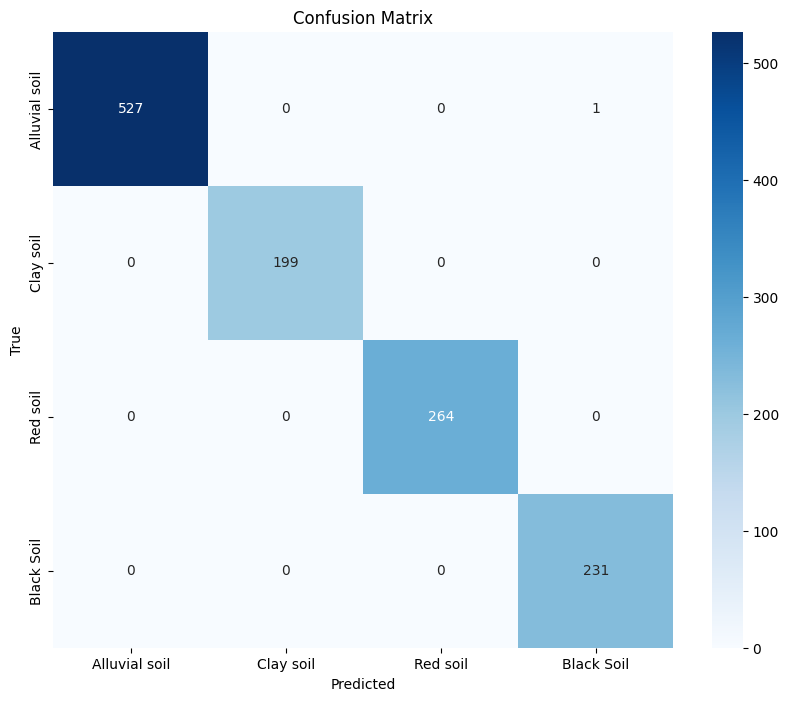

In [24]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[idx2label[i] for i in range(len(idx2label))],
            yticklabels=[idx2label[i] for i in range(len(idx2label))], cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [25]:
from sklearn.metrics import balanced_accuracy_score

bal_acc = balanced_accuracy_score(all_labels, all_preds)
print(f"Balanced Accuracy: {bal_acc:.4f}")


Balanced Accuracy: 0.9995


In [26]:
# ==== SAVE MODEL ==== #  weights
torch.save(model.state_dict(), 'soil_challenge_1_resnet18.pth')

In [27]:
#saing complete model
torch.save(model, "best_model_challenge_1_full.pt")

In [28]:
# ==== INFERENCE ON TEST DATA ==== #
test_df = pd.read_csv(test_csv)
test_df['filename'] = test_df['image_id'].apply(lambda x: os.path.join(TEST_DIR, x))
model.eval()

test_dataset = SoilDataset(test_df, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions = []
with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        predictions.extend(preds)

100%|██████████| 11/11 [00:10<00:00,  1.02it/s]


In [29]:
test_df['soil_type'] = [idx2label[i] for i in predictions]
submission_df = test_df[['image_id', 'soil_type']]
submission_df.to_csv('submission_1.csv', index=False)
print("\n submission.csv generated'")



 submission.csv generated'


In [29]:
import json
from sklearn.metrics import classification_report

# ==== EVALUATION (after training) ==== #
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Classification Report
report_dict = classification_report(true_labels, predicted_labels, target_names=label2idx.keys(), output_dict=True)
report_path = "ml_metrics.json"

# Save as JSON
with open(report_path, "w") as f:
    json.dump(report_dict, f, indent=4)

print(f"✅ Saved classification report to `{report_path}`")


In [30]:
import json
from sklearn.metrics import classification_report

# ==== EVALUATION (after training) ==== #
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Classification Report
report_dict = classification_report(true_labels, predicted_labels, target_names=label2idx.keys(), output_dict=True)
report_path = "ml_metrics.json"

# Save as JSON
with open(report_path, "w") as f:
    json.dump(report_dict, f, indent=4)

print(f" Saved classification report to `{report_path}`")


100%|██████████| 39/39 [00:17<00:00,  2.24it/s]

✅ Saved classification report to `ml_metrics.json`
